In [1]:
#files needed to run the processing. NB utils is a package that Dane helped me make. It includes some important functions in it. 
import utils

import skimage
import napari
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image, ImageDraw

from skimage import data, img_as_float, img_as_ubyte, exposure
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise

from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os
import tifffile as tif

import ipywidgets as widgets



### Load in the dry scan 

In [2]:
# Read the TIFF images for the dry scan 
dirname     = 'E:\\CatHarris\\Nihal\\'
start_slice = 0 #780 for middle section
slices      = 100 #change this is you want to load in more slices NB python starts from 0 



dry_data  = skimage.io.imread('E:\\CatHarris\\Nihal\\Dry_3.tif')


# convert to a 3D array and normalise so data is between 0 and 1 
dry_data  = np.asarray(dry_data) 
dry_data = (dry_data - dry_data.min()) / (dry_data.max() - dry_data.min()) * 255
dry_data  = dry_data.astype(np.uint8)


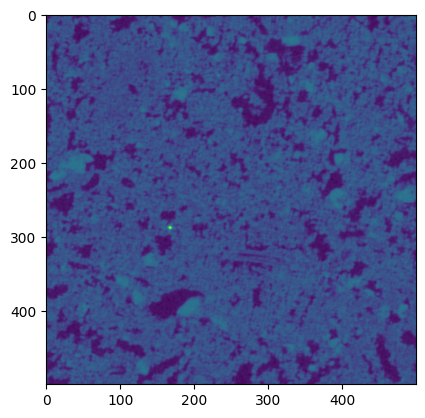

In [3]:
plt.imshow(dry_data[1,:,:])

### Crop to a cylinder 

In [4]:
#NB this code can be edited to change the location and centre of the cylinder for the cropping 

def crop(img):
    z, h, w = img.shape
    
    # creating cylindrical mask
    lum_img = Image.new('L', [h, w], 0)
    draw = ImageDraw.Draw(lum_img)
    draw.pieslice([(135, 90), (h-75, w-75)], 0, 360, fill=255)  #change values here to change the mask shape 
    mask = np.array(lum_img)
    mask = np.repeat(mask[np.newaxis, :, :], z, axis=0)
    mask = (mask == 0)

    assert img.shape == mask.shape
    assert mask.dtype == np.bool8

    foreground = img.copy()
    foreground[mask] = 255

    return foreground

### Non-local means in 3D 

In [3]:
#non-local means filter works better on float of image with no exposure or histogram modification.
dry_float = dry_data.astype(np.float32)

#other potential algorithms that were tested. The fast algorithm did a good job and runs much quicker. Best to use the value calculated from the image itself 
'''
# slow algorithm, sigma provided by user
denoise = denoise_nl_means(dry_float, h=1.2 * sigma, fast_mode=False,
                           **patch_kw)

# slow algorithm
denoise2 = denoise_nl_means(dry_float, h=1.2 * sigma_est, sigma=sigma_est,
                            fast_mode=False, **patch_kw)


# fast algorithm, sigma provided by user 
denoise_fast = denoise_nl_means(dry_float, h=1.2 * sigma, fast_mode=True,
                                **patch_kw)
'''

def nlm_denoise(Img,patch,dist):
    
    def nlm_denoise_wrap(array):
        correct=img_as_float(array[0])
        sigma_est = np.mean(estimate_sigma(correct))
        correct = denoise_nl_means(correct, h=3 * sigma_est, sigma=sigma_est,fast_mode=True,patch_size=patch, patch_distance=dist)
        return correct[np.newaxis, ...]
    
    denoise=skimage.util.apply_parallel(nlm_denoise_wrap,Img, chunks=(1, Img.shape[1],Img.shape[2]), dtype='float',compute=True)
    
    return  denoise

denoise2_fast = nlm_denoise(dry_float, patch = 3,  dist = 6)

### QC of the filtering process 

In [9]:
#note we want the most filtered image that doesn't compromise the boundaries. 
diff_img = denoise2_fast- dry_data

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20),
                       sharex=True, sharey=True)

ax[0].imshow(diff_img[1,400:800, 400:800],cmap='gray')
ax[0].axis('off')


ax[1].imshow(dry_data[1,400:800, 400:800],cmap='gray')
ax[1].axis('off')

ax[2].imshow(denoise2_fast[1,400:800, 400:800],cmap='gray')
ax[2].axis('off')

fig.tight_layout()
plt.show()


#plot of the histograms (entire image, not the zoomed in image)
bins=255
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize =(7, 5))
ax.set_xlabel('Greyscale value')
ax.set_ylabel('Count')

ax.set_xlim(0, 120) 
ax.set_ylim(0, 10**7) 

ax.hist(dry_data.ravel(), bins=bins, histtype='step', color='black')
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))

ax.hist(utils.preprocess(denoise2_fast).ravel(), bins=bins, histtype='step', color='red')
ax.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
ax.legend(['raw data', 'filtered data'])
fig.tight_layout()
plt.show()

NameError: name 'dry_data' is not defined

### Segmentation in 3D 

In [4]:

def phase_segmentation_adapted_watershed(im, pore_thresh):
    #initial 2D code stolen from Griffin Chure

    """
    Performs watershed segmentation on the greyscale image 
    
    Parameters
    ----------
    im : 3D array
        Image to be segmented. 
    
    grain_thresh: float
        Threshold above which grains exist. 
    pore_thresh: float 
        Threshold below which pores exist. 
    
    Output
    -------
    final_seg: segmented image 
    """
    
    # Make sure that the input image is between 0 and 1 
    if np.max(im) != 1.0:
        im = (im - im.min()) / (im.max() - im.min())

    im = im.astype(np.float32)
    #plot histogram with limits of what is pore and what is grain shown
    bins = 255
    fig, ax = plt.subplots(figsize =(10, 7))
    hist_values = im.ravel()
    hist_values = hist_values[hist_values < 0.99]
    y, x, _ = plt.hist(hist_values, bins=bins, histtype='step', color='red')


    # Normal distribution to get the max threshold 
    loc         =  np.argmax(y)                             #find peak 
    update_list = hist_values[hist_values > x[loc]]
    update_y, update_x, _ = plt.hist(update_list, bins=bins, histtype='step', color='red')
    loc2                  =  np.argmax(update_y[update_y< (0.0001 * y.max())])

    grain_thresh = (x[loc] - (update_x[loc2] - x[loc])) *0.85 #currently a 15% leeway 
    print('Threshold value for the grain', grain_thresh)
    plt.axvline(grain_thresh, color='r', linestyle='dashed', linewidth=1)
    plt.axvline(pore_thresh, color='k', linestyle='dashed', linewidth=1)
    plt.show()

    # Generate the catchment basins for watershed
    print('Making the catchment basin')
    basins = np.zeros_like(im)
    basins[im < grain_thresh] = 1
    basins[im > pore_thresh] = 2
    basins = basins.astype(np.float32)

    # Peform the watershed by flooding. 
    print('Flood the basin')
    flood_seg = skimage.segmentation.watershed(im , basins)
    flood_seg = flood_seg > 1.0

    # Compute the distance matrix
    print('Compute the distance matrix')
    distances = ndi.distance_transform_edt(flood_seg)
    
    #Find the maxima NB this is taking a while on 3D images 
    print('Find the maxima')
    local_max = skimage.morphology.local_maxima(distances)
    max_lab = skimage.measure.label(local_max)

    #Perform the topological watershed. 
    print('Perform the topological watershed')
    final_seg = skimage.segmentation.watershed(-distances, max_lab, mask=flood_seg)

    # Remove any stray crap. 
    final_seg = skimage.morphology.remove_small_objects(final_seg, min_size=4)

    #Normalise final_seg 
    final_seg = (final_seg - final_seg.min()) / (final_seg.max() - final_seg.min()) * 255
    # Subresolvable pores - large regions in the middle zone 
    sub_resolvable = utils.simple_thresholding(im, grain_thresh*0.95, pore_thresh*1.15)
    sub_resolvable = skimage.morphology.remove_small_objects(sub_resolvable, min_size=10)   
    print('Pore threshold is', pore_thresh)
    return np.array(final_seg, dtype=np.uint8), np.array(sub_resolvable, dtype=np.uint8)

In [5]:

#delete the unfiltered data to save memory for the segmentation 
del dry_data
del dry_float 



Threshold value for the grain 0.07871894463896752


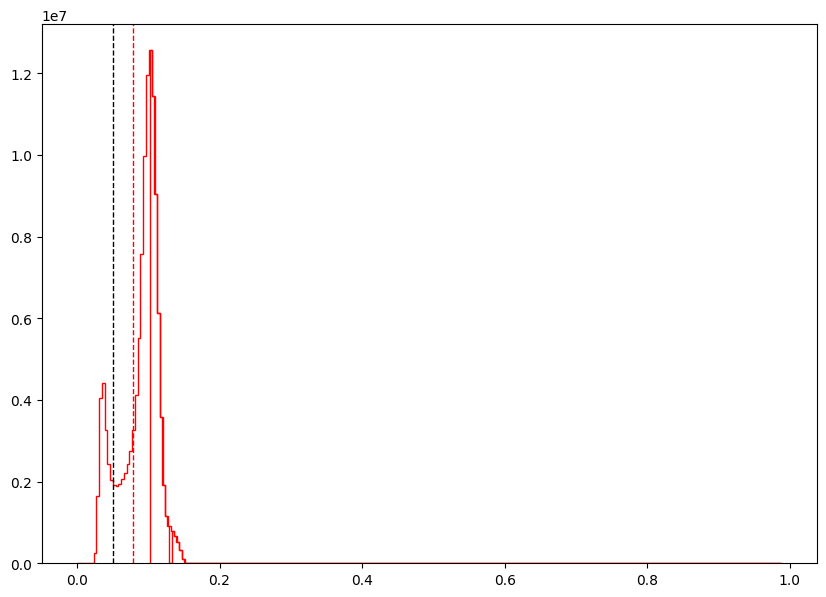

Making the catchment basin
Flood the basin
Compute the distance matrix
Find the maxima
Perform the topological watershed
Pore threshold is 0.05


In [13]:
#perform the segmentation 
#potential to automate the values based on Gaussian curves for the pore space and grains 
input_segmentation                   = img_as_ubyte(utils.preprocess(denoise2_fast.transpose(1,2,0))) #must transpose the image for the input to be xyz, previously zxy
segmented_img, sub_resolved_pores    = phase_segmentation_adapted_watershed(input_segmentation, pore_thresh=0.05)

#NB the histogram is normalised for the segmentation. Currently the mask values are included in this, so if you do a subvolume, then the threshold values need to change. 
#without the mask the values were 0.2 and 0.28 



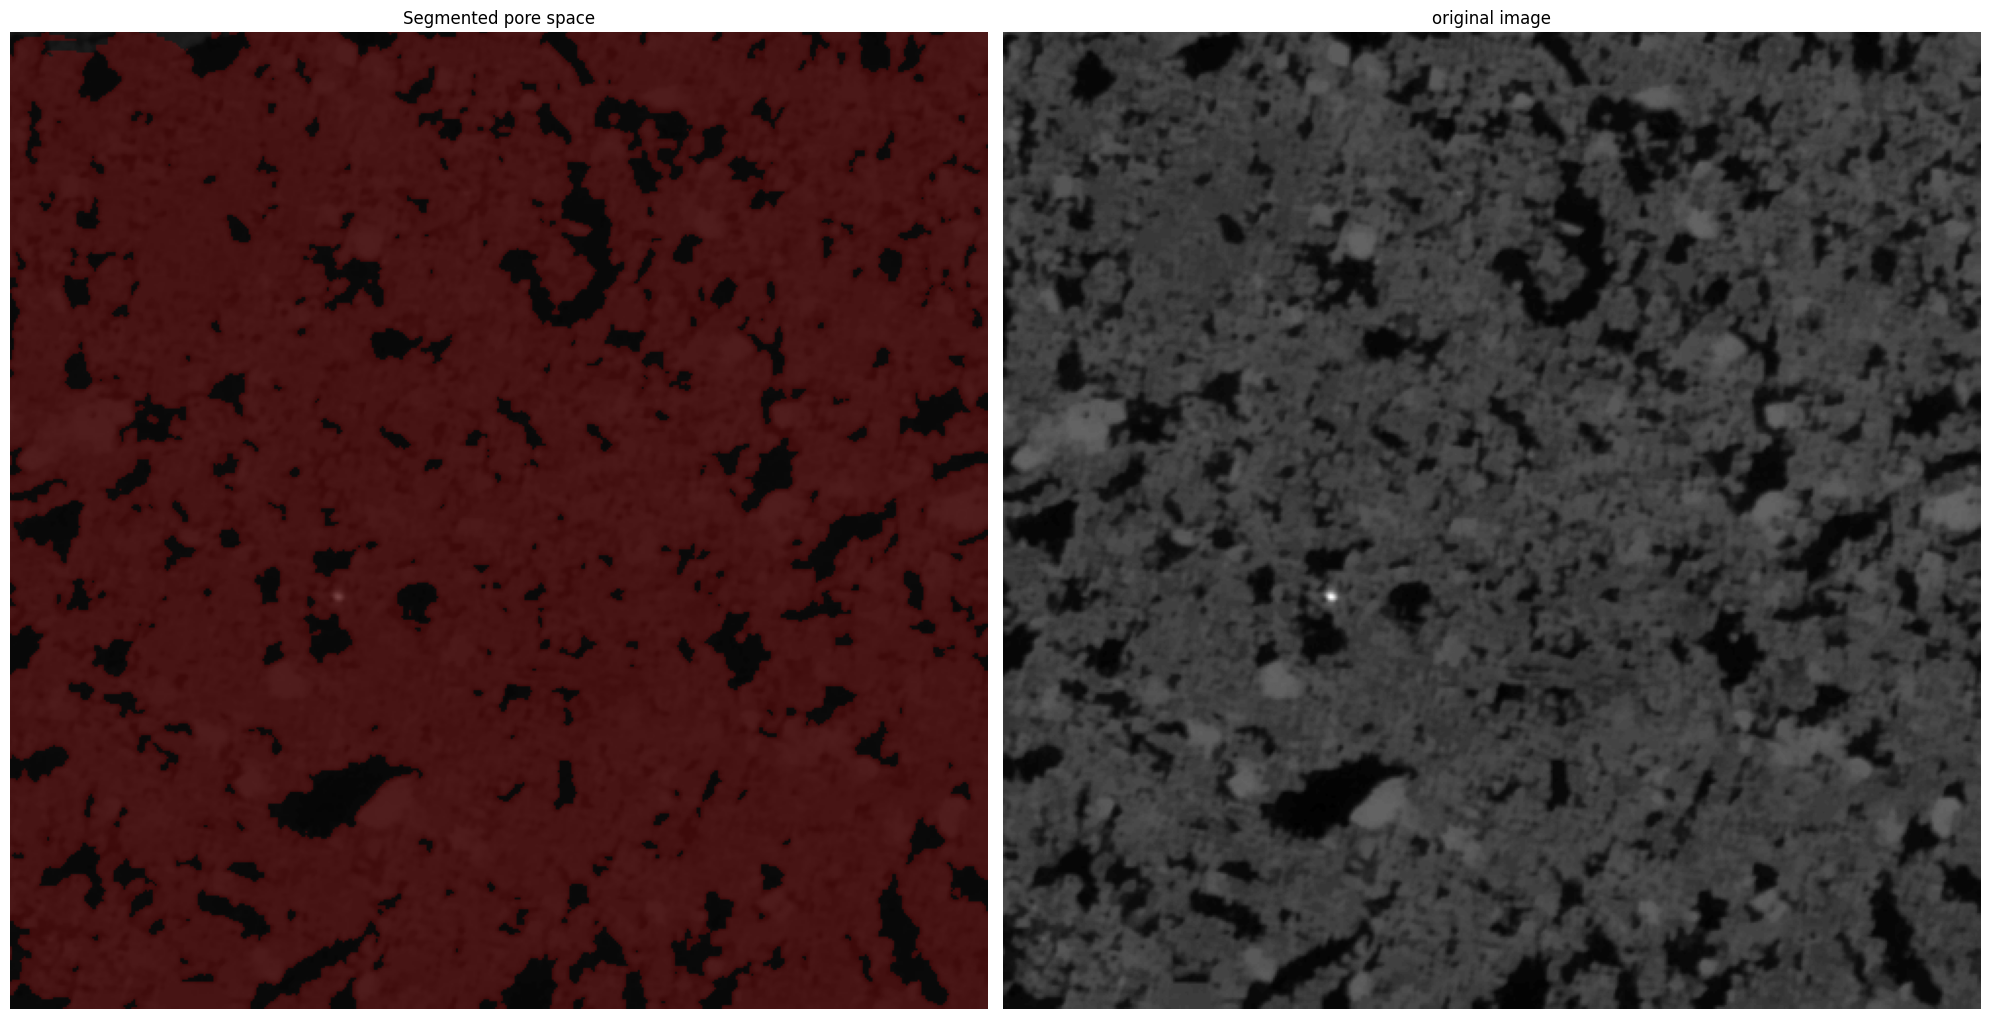

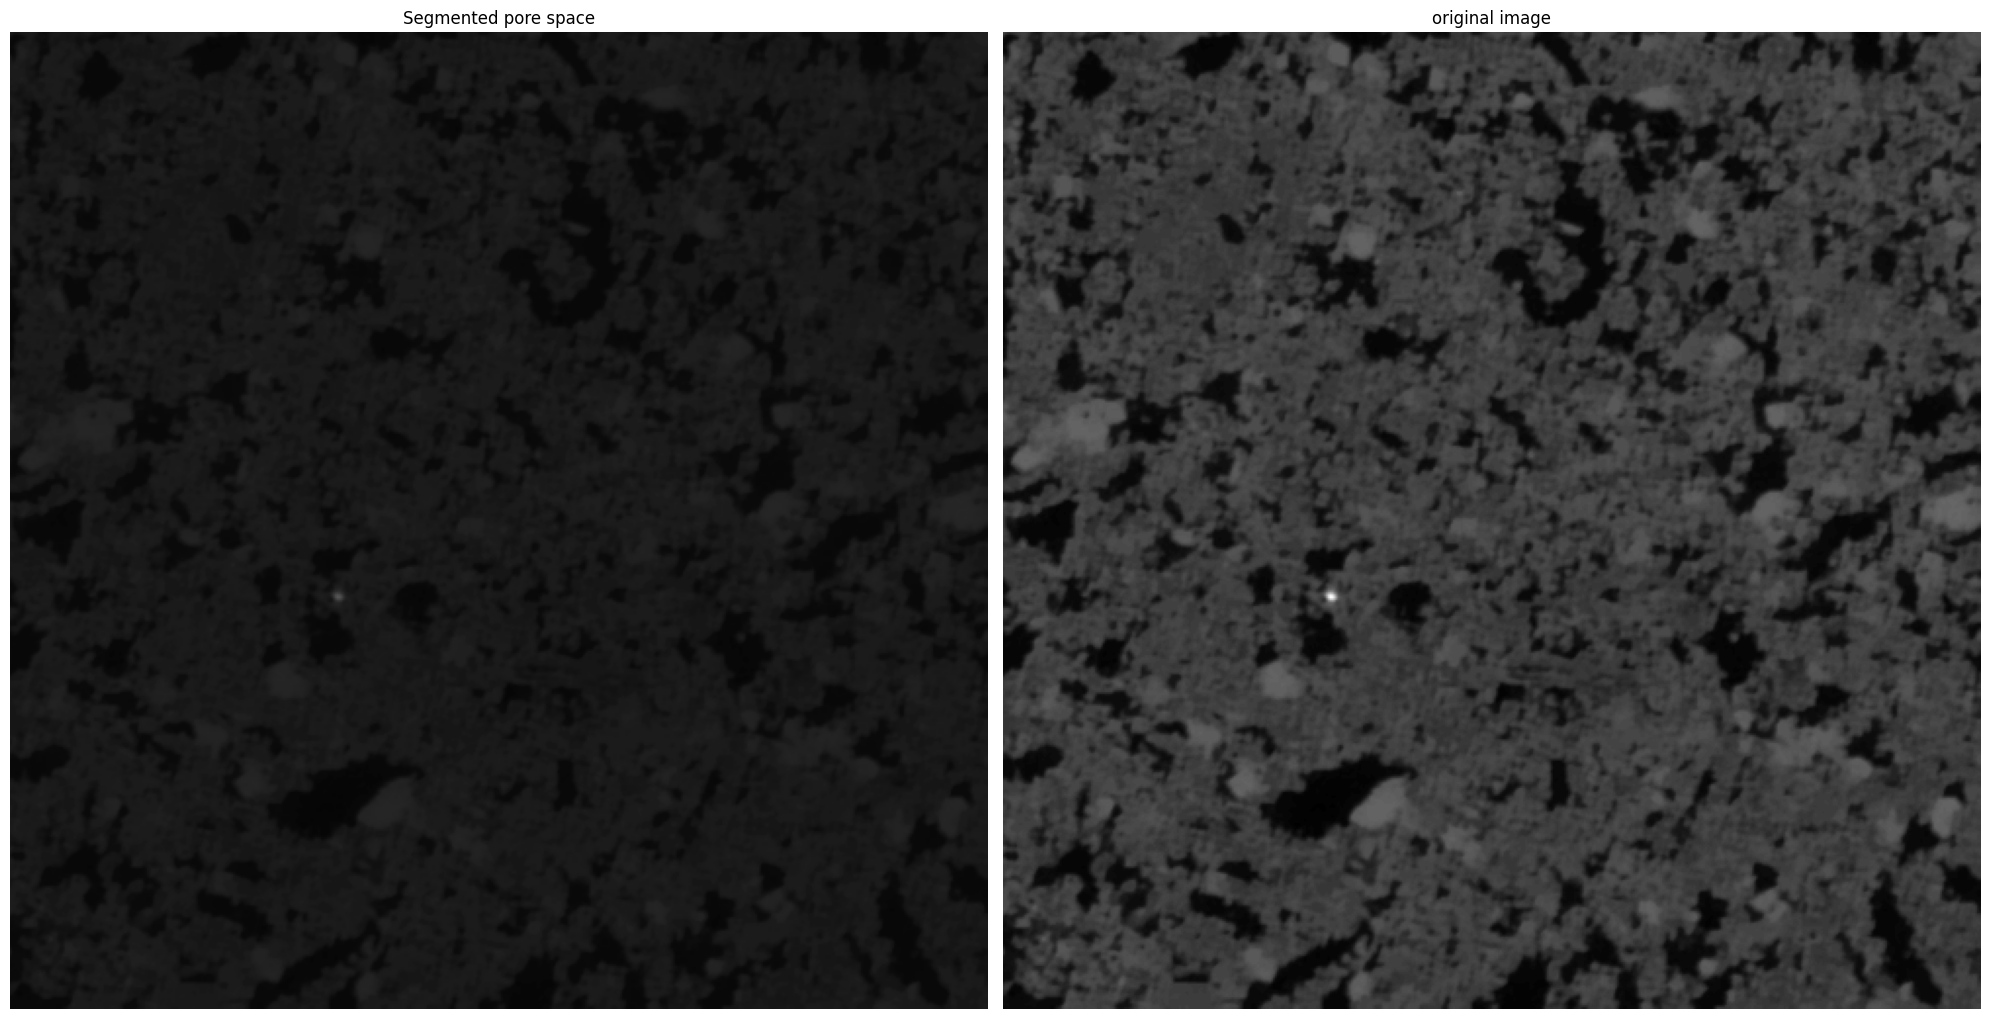

In [19]:
#convert to binary and check the segmentation 
segmented_binary             = np.where(segmented_img>0, 1, segmented_img).astype(np.bool8)
segmented_binary_subpore     = np.where(sub_resolved_pores>0, 1, sub_resolved_pores).astype(np.bool8)
greyscale_input              = (input_segmentation - input_segmentation.min()) / (input_segmentation.max() - input_segmentation.min()) * 255


seg_dry = utils.sanity_check(greyscale_input[:,:,3].astype(np.uint8), segmented_binary[:,:,3], 0.2)
seg_dry_sub = utils.sanity_check(greyscale_input[:,:,3].astype(np.uint8), segmented_binary_subpore[:,:,3], 0.2)



fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20),
                       sharex=True, sharey=True)

ax[0].imshow(seg_dry,cmap='gray')
ax[0].axis('off')
ax[0].set_title('Segmented pore space')


ax[1].imshow(greyscale_input[:,:,3],cmap='gray')
ax[1].axis('off')
ax[1].set_title('original image')

fig.tight_layout()
plt.show()


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20),
                       sharex=True, sharey=True)

ax[0].imshow(seg_dry_sub,cmap='gray')
ax[0].axis('off')
ax[0].set_title('Segmented pore space')


ax[1].imshow(greyscale_input[:,:,3],cmap='gray')
ax[1].axis('off')
ax[1].set_title('original image')

fig.tight_layout()
plt.show()


### Save the image 

In [15]:
segmented_binary_subpore_save = segmented_binary_subpore.transpose(2, 0, 1)
segmented_binary_save         = segmented_binary.transpose(2, 0, 1)

tif.imsave('Nihal_dry.tif', segmented_binary_save, bigtiff=True)
tif.imsave('Nihal_sub_resolved.tif', segmented_binary_subpore_save, bigtiff=True)
#could save sub-resolved separately, or in the same image 

C:\Users\cspurin\AppData\Local\Temp\ipykernel_21240\3129574864.py:4: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tif.imsave('Nihal_dry.tif', segmented_binary_save, bigtiff=True)
C:\Users\cspurin\AppData\Local\Temp\ipykernel_21240\3129574864.py:5: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tif.imsave('Nihal_sub_resolved.tif', segmented_binary_subpore_save, bigtiff=True)


### Play with the result! 

In [14]:
z_widget = widgets.IntSlider(
    value=2,
    min=0,
    max=10,
    step=1,
)


overlay_widget = widgets.RadioButtons(
    options=[True, False],
    description='Overlay:',
    disabled=False,
)


def view_slice(img: np.ndarray, z: int, overlay: bool, mask: bool) -> None:
    depth, h, w = img.shape
    assert isinstance(img, np.ndarray)
    assert isinstance(z, int)
    assert isinstance(overlay, bool)
    assert 0 <= z < depth

    slice = img[:, :, z]

    if overlay:
        slice = utils.preprocess(slice)
        mask  = mask[:, :, z]
        slice = utils.sanity_check(slice, mask)
    fig = plt.figure(figsize=(20, 12))
    plt.imshow(slice, cmap='gray')
    plt.show()


widgets.interact(view_slice, img=widgets.fixed(greyscale_input[500:1000,500:1000,:]), z=z_widget, overlay=overlay_widget, mask = widgets.fixed(segmented_binary[500:1000,500:1000,:] ))

interactive(children=(IntSlider(value=2, description='z', max=10), RadioButtons(description='Overlay:', option…

<function __main__.view_slice(img: numpy.ndarray, z: int, overlay: bool, mask: bool) -> None>

In [15]:
#abandoned parallel processing
'''
    def find_local_max(Img):
    
        def find_local_max_wrap(array):
            correct_img   = array[0]
            correct_img   = skimage.feature.peak_local_max(correct_img, indices=False, footprint=None)
            return correct_img[np.newaxis, ...]
    
        local_max=skimage.util.apply_parallel(find_local_max_wrap, Img, chunks=(1, Img.shape[1],Img.shape[2]), dtype='float',compute=True)
    
        return  local_max
    

    local_max = find_local_max(distances)
'''

"\n    def find_local_max(Img):\n    \n        def find_local_max_wrap(array):\n            correct_img   = array[0]\n            correct_img   = skimage.feature.peak_local_max(correct_img, indices=False, footprint=None)\n            return correct_img[np.newaxis, ...]\n    \n        local_max=skimage.util.apply_parallel(find_local_max_wrap, Img, chunks=(1, Img.shape[1],Img.shape[2]), dtype='float',compute=True)\n    \n        return  local_max\n    \n\n    local_max = find_local_max(distances)\n"